# Preparation

In [124]:
import os
import warnings
import logging
import pickle
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample

import config

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
logger = logging.getLogger()
warnings.filterwarnings("ignore")

In [12]:
# Global parameters

# random forests
param_grid_rf =  {
    'n_estimators' : [10, 20, 30, 40, 50, 100, 1000],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# SVM
param_grid_svm = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': np.logspace(-2, 1, 4),
    'gamma': np.logspace(-3, 1, 5)
}

forest = RandomForestClassifier(random_state=RANDOM_STATE)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE))

## Data loading

In [9]:
matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0226_15-16-44Features-157015.xlsx')
matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0226_17-18-28Features-agent-157015.xlsx')
matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0227_20-11-53Features-nophase.xlsx')
matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0227_22-43-15Features-agent-nophase.xlsx') 

def prepare_df(df):
    df = df.drop(['Presence Score', 'Co-presence Score'], axis=1)
    df = df.rename(index=str,
                   columns={"Presence Class": "PresenceClass", "Co-presence Class": "CopresenceClass"})
    return df

def dfval(df, candidate, environment, column):
    return df.query("Candidate == '%s' & Environment == '%s'" % (candidate, environment))[column].values

print("Loading data - phases split ...")

subject_p_df = pd.read_excel(matrix_subject_phases)
subject_p_df = prepare_df(subject_p_df)
print("   Subject: %d samples" % len(subject_p_df))
agent_p_df = pd.read_excel(matrix_agent_phases)
agent_p_df = prepare_df(agent_p_df)
print("   Agent: %d samples" % len(agent_p_df))

all_p_df = pd.merge(subject_p_df, agent_p_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_agent'))
all_p_df = all_p_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge: %d samples (common to subject and agent)" % len(all_p_df))

subject_p_df = pd.merge(subject_p_df, all_p_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_toberemoved'))
subject_p_df = subject_p_df.drop([col for col in subject_p_df.columns if col.endswith('_toberemoved') ], axis=1)
print("   Subject merged check: %s" % len(subject_p_df))

agent_p_df = pd.merge(agent_p_df, all_p_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_toberemoved'))
# computed duration is different for agent but this is due to how it's computed, let it be the same value as for subject
agent_p_df = agent_p_df.drop(['Duration'], axis=1)
agent_p_df = agent_p_df.rename(index=str, columns={'Duration_toberemoved': 'Duration'})
agent_p_df = agent_p_df.drop([col for col in agent_p_df.columns if col.endswith('_toberemoved')], axis=1)
print("   Agent merged check: %s" % len(agent_p_df))

# no phase

subject_np_df = pd.read_excel(matrix_subject_nophase)
subject_np_df = prepare_df(subject_np_df)
print("   Subject(no phase): %d samples" % len(subject_np_df))
agent_np_df = pd.read_excel(matrix_agent_nophase)
agent_np_df = prepare_df(agent_np_df)
print("   Agent(no phase): %d samples" % len(agent_np_df))

all_np_df = pd.merge(subject_np_df, agent_np_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_agent'))
all_np_df = all_np_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge: %d samples (common to subject and agent)" % len(all_np_df))

subject_np_df = pd.merge(subject_np_df, all_np_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_toberemoved'))
subject_np_df = subject_np_df.drop([col for col in subject_np_df.columns if col.endswith('_toberemoved') ], axis=1)
print("   Subject merged check: %s" % len(subject_np_df))

agent_np_df = pd.merge(agent_np_df, all_np_df, on=['Candidate', 'Environment'], how='inner', suffixes=('', '_toberemoved'))
# computed duration is different for agent but this is due to how it's computed, let it be the same value as for subject
agent_np_df = agent_np_df.drop(['Duration'], axis=1)
agent_np_df = agent_np_df.rename(index=str, columns={'Duration_toberemoved': 'Duration'})
agent_np_df = agent_np_df.drop([col for col in agent_np_df.columns if col.endswith('_toberemoved')], axis=1)
print("   Agent merged check: %s" % len(agent_np_df))

Loading data - phases split ...
   Subject: 83 samples
   Agent: 95 samples
   Merge: 81 samples (common to subject and agent)
   Subject merged check: 81
   Agent merged check: 81
   Subject(no phase): 86 samples
   Agent(no phase): 92 samples
   Merge: 81 samples (common to subject and agent)
   Subject merged check: 81
   Agent merged check: 81


In [64]:
# todo "Avg_IPUlen_Begin", "Avg_IPUlen_Middle", "Avg_IPUlen_End" removed because of wrong values
subject_features = ("Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

# not using "Expert" feature for agent features
agent_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

all_features = subject_features + tuple(feat+'_agent' for feat in agent_features if feat is not 'Duration')

subject_features_nophase = ("Expert", "Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
                            "Ratio2_Mid", "Duration")

agent_features_nophase = ("Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
                            "Ratio2_Mid", "Duration")

all_features_nophase = subject_features_nophase + tuple(feat+'_agent' for feat in agent_features if feat is not 'Duration')

# verbal features

subject_features_verbal = ("Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
                            "Ratio2_Mid")

agent_features_verbal = ("Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
                            "Ratio2_Mid")

all_features_verbal = subject_features_nophase + tuple(feat+'_agent' for feat in agent_features if feat is not 'Duration')

# non-verbal features

subject_features_nonverbal = ("Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
                            "Ratio2_Mid")

agent_features_nonverbal = ("Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
                            "Ratio2_Mid")

all_features_nonverbal = subject_features_nophase + tuple(feat+'_agent' for feat in agent_features if feat is not 'Duration')

out_path = os.path.join(config.OUT_PATH, 'gridsearchcv')
if not os.path.exists(out_path): os.makedirs(out_path)

def gscv_name(presence=True, doctor=True, agent=False, phases=None, classifier='RF'):
    pres = 'presence' if presence else 'copresence'
    subject = 'doctor' if doctor else ''
    subject = subject + ('agent' if agent else '')
    ph = 'nophase' if phases is None else '%d%d%d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    return "%s_%s_%s_%s" % (pres, subject, ph, classifier)

def save_gscv(grid, presence=True, doctor=True, agent=False, phases=None, classifier='RF'):
    name = "grid_%s.pkl" % (gscv_name(presence, doctor, agent, phases, classifier))
    f = open(os.path.join(out_path, name), 'wb')
    pickle.dump(grid, f)
    f.close()
    
def load_gscv(presence=True, doctor=True, phases=None, classifier='RF'):
    name = "grid_%s.pkl" % (gscv_name(presence, doctor, agent, phases, classifier))
    f = open(os.path.join(out_path, name), 'rb')
    grid = pickle.load(f)
    f.close()
    return grid

def save_results(rdf):
    try:
        frdf_name = 'results.pkl'
        frdf = open(os.path.join(out_path, frdf_name), 'wb')
        pickle.dump(rdf, frdf)
        frdf.close()
    except Exception as e:
        print('Could not save results file %s' % (os.path.join(out_path, frdf_name)))
        print(e)
        return False
    return True

def load_results():
    try:
        frdf_name = 'results.pkl'
        frdf = open(os.path.join(out_path, frdf_name), 'rb')
        rdf = pickle.load(frdf)
        frdf.close()
    except Exception:
        print('results file does not yet exist')
        return None
    return rdf

def prepare_train_data(samples, modelTarget, features, upsample=False):
    
    names = features
    
    samples_split = []
    if (modelTarget == "presence"):
        samples_split.append(samples[samples.PresenceClass == 1])
        samples_split.append(samples[samples.PresenceClass == 2])
        samples_split.append(samples[samples.PresenceClass == 3])

    elif (modelTarget == "copresence"):
        samples_split.append(samples[samples.CopresenceClass == 1])
        samples_split.append(samples[samples.CopresenceClass == 2])
        samples_split.append(samples[samples.CopresenceClass == 3])
    else:
        sys.exit("Invalid input. Please pick between presence and copresence")

    maxClassSize = max(samples_split[0].shape[0], samples_split[1].shape[0], samples_split[2].shape[0])

    if upsample:
        upsampled = []
        # todo upsample with SMOTE algorithm ? https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
        for idx, samples in enumerate(samples_split):
            if (samples.shape[0] == maxClassSize):
                upsampled.append(samples)
            else:
                logger.debug("resample: adding " + str(maxClassSize - samples.shape[0]) + " samples to class " + str(
                    idx + 1) + " to reach " + str(maxClassSize))
                upsampled.append(resample(samples, replace=True, n_samples=maxClassSize, random_state=None))

        balanced_set = pd.concat(upsampled)
        X = np.nan_to_num(balanced_set.as_matrix(names))

        if (modelTarget == "presence"):
            y = np.array(balanced_set["PresenceClass"].tolist())

        else:
            y = np.array(balanced_set["CopresenceClass"].tolist())

    else:

        X = np.nan_to_num(samples[list(names)])
        if modelTarget == "presence":
            y = samples.PresenceClass
        else:
            y = samples.CopresenceClass
            
    return X, y

def gridsearch(clf, X, y, modelTarget, param_grid, features, upsample=False, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #logger.debug("X_train ", X_train.shape, "X_test", X_test.shape, "y_train", y_train.shape, "y_test", y_test.shape)

  # todo move to beginning with other imports

    #n_estimators = np.concatenate((np.arange(1,10), np.arange(10,100,10)))
    print(np.unique(y, return_counts=True))
    grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                        scoring=['f1_macro', 'precision_macro', 'recall_macro'],
                        refit='f1_macro',
                        cv=10,
                        return_train_score=True,
                        verbose=verbose)

    grid = grid.fit(X, y)

    results = grid.cv_results_
    # print("best params ", grid.best_params_)
    # print("best score ", grid.best_score_)

    return grid

def run_cross_val_score(clf, X, y, modelTarget, param_grid, features, upsample=False, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    return cross_validate(clf, X, y, scoring=['f1_macro', 'precision_macro', 'recall_macro', 'f1'], cv=10, verbose=verbose)

('Expert', 'Head_Entropy_Start', 'Head_Entropy_Mid', 'Head_Entropy_End', 'Avg_HandEntropy_Begin', 'Avg_HandEntropy_Mid', 'Avg_HandEntropy_End', 'Avg_SentenceLength_Begin', 'Avg_SentenceLength_Mid', 'Avg_SentenceLength_End', 'Ratio1_Begin', 'Ratio1_Mid', 'Ratio1_End', 'Ratio2_Begin', 'Ratio2_Mid', 'Ratio2_End', 'Duration', 'Head_Entropy_Start_agent', 'Head_Entropy_Mid_agent', 'Head_Entropy_End_agent', 'Avg_HandEntropy_Begin_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_HandEntropy_End_agent', 'Avg_SentenceLength_Begin_agent', 'Avg_SentenceLength_Mid_agent', 'Avg_SentenceLength_End_agent', 'Ratio1_Begin_agent', 'Ratio1_Mid_agent', 'Ratio1_End_agent', 'Ratio2_Begin_agent', 'Ratio2_Mid_agent', 'Ratio2_End_agent')
('Expert', 'Head_Entropy_Mid', 'Avg_HandEntropy_Mid', 'Avg_SentenceLength_Mid', 'Ratio1_Mid', 'Ratio2_Mid', 'Duration', 'Head_Entropy_Start_agent', 'Head_Entropy_Mid_agent', 'Head_Entropy_End_agent', 'Avg_HandEntropy_Begin_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_HandEntropy_End_agen

In [213]:
# prepare results
def update_results(cv_results_, rdf, p1, p2, p3, p4):
    df = pd.DataFrame(cv_results_)
    best_precision = df.mean_test_precision_macro.max()
    df_best = df.loc[df['mean_test_precision_macro'] == best_precision]
    rdf.at[(p1, p2, p3, p4), 'precision'] = df_best.mean_test_precision_macro.values[0]
    rdf.at[(p1, p2, p3, p4), 'f1'] = df_best.mean_test_f1_macro.values[0]
    rdf.at[(p1, p2, p3, p4), 'recall'] = df_best.mean_test_recall_macro.values[0]
    rdf.at[(p1, p2, p3, p4), 'params'] = str(df_best.params.values[0])
    #print("%s %s %s %s %s" % (p1, p2, p3, p4, str(rdf.at[p1, p2, p3, p4])))
    save_results(rdf)
    return rdf

rdf_index = [['Presence', 'Co-Presence'], ['Doctor', 'Agent', 'Doctor+Agent'], ['No Phase', '157015'], ['Random Forests', 'SVM']]
rdf_columns = ['precision', 'f1', 'recall', 'params']
rdf_multiindex = pd.MultiIndex.from_product(rdf_index, names=['Metric', 'Subject', 'Phases', 'Classifier'])

rdf = load_results()
if rdf is None:
    rdf = pd.DataFrame(np.zeros((24,4)), index=rdf_multiindex, columns=rdf_columns)
    rdf['params'] = rdf['params'].apply(str)
    rdf['params'] = ''
    save_results(rdf)
rdf

precision        f1  \
Metric      Subject      Phases   Classifier                            
Presence    Doctor       No Phase Random Forests   0.816032  0.776039   
                                  SVM              0.843900  0.801139   
                         157015   Random Forests   0.778753  0.723586   
                                  SVM              0.927302  0.892880   
            Agent        No Phase Random Forests   0.763946  0.733961   
                                  SVM              0.818995  0.784713   
                         157015   Random Forests   0.810794  0.754127   
                                  SVM              0.883039  0.793964   
            Doctor+Agent No Phase Random Forests   0.844444  0.808904   
                                  SVM              0.898753  0.843911   
                         157015   Random Forests   0.782381  0.747407   
                                  SVM              0.913515  0.862339   
Co-Presence Doctor       No Phase Random Forests   0.821652  0.798101   
                                  SVM              0.897212  0.821709   
                         157015   Random Forests   0.843895  0.775644   
                                  SVM              0.881481  0.855305   
            Agent        No Phase Random Forests   0.916809  0.893617   
                                  SVM              0.920391  0.870184   
                         157015   Random Forests   0.857977  0.843006   
                                  SVM              0.919678  0.882360   
            Doctor+Agent No Phase Random Forests   0.868091  0.827934   
                                  SVM              0.890761  0.862064   
                         157015   Random Forests   0.891758  0.857478   
                                  SVM              0.891209  0.858275   

                                                    recall  \
Metric      Subject      Phases   Classifier                 
Presence    Doctor       No Phase Random Forests  0.780952   
                                  SVM             0.809524   
                         157015   Random Forests  0.742857   
                                  SVM             0.895238   
            Agent        No Phase Random Forests  0.742857   
                                  SVM             0.809524   
                         157015   Random Forests  0.771429   
                                  SVM             0.800000   
            Doctor+Agent No Phase Random Forests  0.819048   
                                  SVM             0.847619   
                         157015   Random Forests  0.752381   
                                  SVM             0.866667   
Co-Presence Doctor       No Phase Random Forests  0.803419   
                                  SVM             0.837607   
                         157015   Random Forests  0.794872   
                                  SVM             0.871795   
            Agent        No Phase Random Forests  0.897436   
                                  SVM             0.880342   
                         157015   Random Forests  0.846154   
                                  SVM             0.888889   
            Doctor+Agent No Phase Random Forests  0.837607   
                                  SVM             0.880342   
                         157015   Random Forests  0.863248   
                                  SVM             0.871795   

                                                                                             params  
Metric      Subject      Phases   Classifier                                                         
Presence    Doctor       No Phase Random Forests  {'max_features': 'auto', 'n_estimators': 50, '...  
                                  SVM                    {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1}  
                         157015   Random Forests  {'max_features': 'auto', 'n_estimators': 40, '...  
                            

In [13]:
# combinations to be ran
from sklearn.model_selection import ParameterGrid
test_plan_params = {
    'classifier': ['svm'],
    'subject': ['doctor', 'agent', 'doctor+agent'],
    'target': ['presence', 'copresence'],
    'phases': [(0.15,0.70,0.15), (0,1,0)]
}
test_plan = list(ParameterGrid(test_plan_params))
print("%d tests to be performed" % len(test_plan))
for test in test_plan:
    print(test)

12 tests to be performed
{'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor'}
{'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor'}
{'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'svm', 'subject': 'agent'}
{'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'svm', 'subject': 'agent'}
{'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor+agent'}
{'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor+agent'}
{'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor'}
{'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor'}
{'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'svm', 'subject': 'agent'}
{'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'svm', 'subject': 'agent'}
{'phases': (0, 1, 0), 'target': 'presence', 'clas

# Test Plan

In [30]:
for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))

    subject = test['subject']
    target = test['target']
    phases = test['phases']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid if classifier == 'forest' else param_grid_svm

    if phases is not None and phases is not (0,1,0):
        if subject == 'doctor':
            df = subject_p_df
            feats = subject_features
        elif subject == 'agent':
            df = agent_p_df
            feats = agent_features
        elif subject == 'doctor+agent':
            df = all_p_df
            feats=all_features
    else:
        if subject == 'doctor':
            df = subject_np_df
            feats = subject_features_nophase
        elif subject == 'agent':
            df = agent_np_df
            feats = agent_features_nophase
        elif subject == 'doctor+agent':
            df = all_np_df
            feats=all_features_nophase   
    
    grid = gridsearch(clf, df, target, param_grid=pgrid, features=feats, upsample=True)
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    save_gscv(grid, presence=target=='presence', doctor=isDoc, agent=isAgent,
             phases=phases, classifier='RF' if test['classifier']=='forest' else 'SVM')
    
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    phidx = 'No Phase' if phases in [None, (0,1,0)] else '%2d%2d%2d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'
    print("      updating %s %s %s %s" % (presidx, subjidx, phidx, clfidx))
    rdf = update_results(grid.cv_results_, rdf, presidx, subjidx, phidx, clfidx)
    dumpPath = os.path.join(config.OUT_PATH, 'gridsearchcv', 'results.xlsx')
    rdf.to_excel(dumpPath, index=True)

Test 0 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.9min finished


      updating Presence Doctor 157015 SVM
Test 1 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   39.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Co-Presence Doctor 157015 SVM
Test 2 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'svm', 'subject': 'agent'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Presence Agent 157015 SVM
Test 3 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'svm', 'subject': 'agent'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   45.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Co-Presence Agent 157015 SVM
Test 4 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor+agent'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   39.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Presence Doctor+Agent 157015 SVM
Test 5 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor+agent'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   49.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Co-Presence Doctor+Agent 157015 SVM
Test 6 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   59.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Presence Doctor No Phase SVM
Test 7 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Co-Presence Doctor No Phase SVM
Test 8 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'svm', 'subject': 'agent'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Presence Agent No Phase SVM
Test 9 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'svm', 'subject': 'agent'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   53.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Co-Presence Agent No Phase SVM
Test 10 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor+agent'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   51.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      updating Presence Doctor+Agent No Phase SVM
Test 11 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor+agent'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits
      updating Co-Presence Doctor+Agent No Phase SVM


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   49.9s finished


# Results summary

In [162]:
rdf

precision        f1  \
Metric      Subject      Phases   Classifier                            
Presence    Doctor       No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.896508  0.852215   
                                  SVM              0.000000  0.000000   
            Agent        No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.798254  0.762850   
                                  SVM              0.000000  0.000000   
            Doctor+Agent No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.856372  0.784093   
                                  SVM              0.000000  0.000000   
Co-Presence Doctor       No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
            Agent        No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
            Doctor+Agent No Phase Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   
                         157015   Random Forests   0.000000  0.000000   
                                  SVM              0.000000  0.000000   

                                                    recall  \
Metric      Subject      Phases   Classifier                 
Presence    Doctor       No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.857143   
                                  SVM             0.000000   
            Agent        No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.771429   
                                  SVM             0.000000   
            Doctor+Agent No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.800000   
                                  SVM             0.000000   
Co-Presence Doctor       No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   
            Agent        No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   
            Doctor+Agent No Phase Random Forests  0.000000   
                                  SVM             0.000000   
                         157015   Random Forests  0.000000   
                                  SVM             0.000000   

                                                                                             params  
Metric      Subject      Phases   Classifier                                                         
Presence    Doctor       No Phase Random Forests                                                     
                                  SVM                                                                
                         157015   Random Forests  {'max_features': 'auto', 'n_estimators': 40, '...  
                            

## Specific tests on 'Expert' feature

In [42]:
# specific test on expert importance

subject_features = ("Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

subject_noexpert_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

# not using "Expert" feature for agent features
agent_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

In [43]:
grid1 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_features, upsample=True)
df = pd.DataFrame(grid1.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_1 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val1 = df_best_1.iloc[0]
df_best_1 = pd.DataFrame(df_best_val1.values, columns=['Doctor / Expert'], index=df_best_1.columns).T
df_best_1

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  6.1min finished


ValueError: Shape of passed values is (2, 83), indices imply (1, 83)

In [62]:
grid2 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_noexpert_features, upsample=True)
df = pd.DataFrame(grid2.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_ = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val2 = df_best_2.iloc[0]
df_best_2 = pd.DataFrame(df_best_val2.values, columns=['Doctor / No Expert'], index=df_best_2.columns).T
df_best_2

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.1min finished


In [63]:
grid3 = gridsearch(forest, agent_p_df, 'presence', param_grid=param_grid, features=agent_features, upsample=True)
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.0min finished


ValueError: Shape of passed values is (6, 83), indices imply (1, 83)

In [64]:
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

,mean_fit_time,mean_score_time,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_train_f1_macro,mean_train_precision_macro,mean_train_recall_macro,param_class_weight,param_max_features,...,split9_train_precision_macro,split9_train_recall_macro,std_fit_time,std_score_time,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro
Agent / No Expert,0.0141,0.00369997,0.773156,0.831852,0.780952,0.997849,0.997917,0.997849,None,auto,...,1,1,0.00418211,0.00414847,0.118873,0.0914799,0.11225,0.00430219,0.00416667,0.00430108


In [65]:
df_best_all = pd.concat([df_best_1, df_best_2, df_best_3])
df_best_all[['mean_test_precision_macro', 'mean_test_f1_macro', 'mean_test_recall_macro', 'params']]

,mean_test_precision_macro,mean_test_f1_macro,mean_test_recall_macro,params
Doctor / Expert,0.814921,0.746969,0.761905,"{u'max_features': None, u'n_estimators': 50, u..."
Doctor / No Expert,0.836531,0.793405,0.8,"{u'max_features': None, u'n_estimators': 100, ..."
Agent / No Expert,0.831852,0.773156,0.780952,"{u'max_features': u'auto', u'n_estimators': 10..."


In [68]:
df = pd.DataFrame(grid1.cv_results_)
cols = [col for col in df.columns if 'std' in col]
df[cols]

,std_fit_time,std_score_time,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro
0,0.002871,0.002256,0.132134,0.165828,0.121312,0.004827,0.004678,0.004826
1,0.003661,0.001814,0.133546,0.166498,0.118634,0.003126,0.003030,0.003125
2,0.034886,0.003231,0.143855,0.179382,0.125628,0.000000,0.000000,0.000000
3,0.007099,0.004826,0.115380,0.097104,0.114120,0.000000,0.000000,0.000000
4,0.005590,0.002193,0.109027,0.079613,0.109971,0.000000,0.000000,0.000000
5,0.008237,0.003716,0.130162,0.124520,0.121187,0.000000,0.000000,0.000000
6,0.035410,0.018779,0.133596,0.128389,0.123044,0.000000,0.000000,0.000000
7,0.003807,0.003873,0.084147,0.073661,0.088363,0.004168,0.004040,0.004167
8,0.008453,0.002764,0.110407,0.116601,0.101872,0.000000,0.000000,0.000000
9,0.009600,0.004331,0.117534,0.126775,0.116220,0.000000,0.000000,0.000000


In [197]:
def plot_importance(title, importances, importances_err, feature_names, sort=True):
    # Sort feature importances in descending order
    if sort:
        indices = np.argsort(importances)[::-1]
    else:
        indices = np.arange(len(feature_names))

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    if importances_err is not None:
        errs = [importances_err[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance - " + title)

    # Add bars
    if importances_err is not None:
        plt.bar(range(len(feature_names)), importances[indices], yerr=errs, xerr=0.1)
    else:
        plt.bar(range(len(feature_names)), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(len(feature_names)), names, rotation=90)

    # Show plot
    plt.show()
    
plot_importance('Doctor / Expert', grid1.best_estimator_.feature_importances_, None, subject_features, sort=False)
plot_importance('Doctor / No expert', grid2.best_estimator_.feature_importances_, None, subject_noexpert_features, sort=False)
plot_importance('Agent / No expert', grid3.best_estimator_.feature_importances_, None, agent_features, sort=False)

NameError: name 'grid1' is not defined

In [249]:
import numpy as np, scipy.stats as st

def confint(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

a = [1, 1.1, 0.9, 1.15, 0.8, 1.03, 0.99]
print(confint(a))

(0.8866952590268444, 1.1047333124017271)


In [40]:
rdf.index = rdf.index.swaplevel(2,3)
rdf.sort_index(inplace=True)

In [71]:
rdf

precision        f1  \
Classifier     Metric      Phases   Subject                             
Random Forests Co-Presence 157015   Agent          0.857977  0.843006   
                                    Doctor         0.843895  0.775644   
                                    Doctor+Agent   0.891758  0.857478   
                           No Phase Agent          0.916809  0.893617   
                                    Doctor         0.821652  0.798101   
                                    Doctor+Agent   0.868091  0.827934   
               Presence    157015   Agent          0.810794  0.754127   
                                    Doctor         0.778753  0.723586   
                                    Doctor+Agent   0.782381  0.747407   
                           No Phase Agent          0.763946  0.733961   
                                    Doctor         0.816032  0.776039   
                                    Doctor+Agent   0.844444  0.808904   
SVM            Co-Presence 157015   Agent          0.919678  0.882360   
                                    Doctor         0.881481  0.855305   
                                    Doctor+Agent   0.891209  0.858275   
                           No Phase Agent          0.920391  0.870184   
                                    Doctor         0.897212  0.821709   
                                    Doctor+Agent   0.890761  0.862064   
               Presence    157015   Agent          0.883039  0.793964   
                                    Doctor         0.927302  0.892880   
                                    Doctor+Agent   0.913515  0.862339   
                           No Phase Agent          0.818995  0.784713   
                                    Doctor         0.843900  0.801139   
                                    Doctor+Agent   0.898753  0.843911   

                                                    recall  \
Classifier     Metric      Phases   Subject                  
Random Forests Co-Presence 157015   Agent         0.846154   
                                    Doctor        0.794872   
                                    Doctor+Agent  0.863248   
                           No Phase Agent         0.897436   
                                    Doctor        0.803419   
                                    Doctor+Agent  0.837607   
               Presence    157015   Agent         0.771429   
                                    Doctor        0.742857   
                                    Doctor+Agent  0.752381   
                           No Phase Agent         0.742857   
                                    Doctor        0.780952   
                                    Doctor+Agent  0.819048   
SVM            Co-Presence 157015   Agent         0.888889   
                                    Doctor        0.871795   
                                    Doctor+Agent  0.871795   
                           No Phase Agent         0.880342   
                                    Doctor        0.837607   
                                    Doctor+Agent  0.880342   
               Presence    157015   Agent         0.800000   
                                    Doctor        0.895238   
                                    Doctor+Agent  0.866667   
                           No Phase Agent         0.809524   
                                    Doctor        0.809524   
                                    Doctor+Agent  0.847619   

                                                                                             params  
Classifier     Metric      Phases   Subject                                                          
Random Forests Co-Presence 157015   Agent         {'max_features': None, 'n_estimators': 40, 'cl...  
                                    Doctor        {'max_features': None, 'n_estimators': 10, 'cl...  
                                    Doctor+Agent  {'max_features': 'auto', 'n_estimators': 100, ...  
                           N

# Features importance experiments

We would like to check variance and quality of this estimator.
For this we first experiment cross validations with searching also n_estimators, or fixing it with a high value, and check if and how best parameters vary.
Then we will check for a specific set of params, how results and feature importance vary upon repeated runs.
Depending on results, we will compute feature importance for all test plan.

In [202]:
# from rfpimp - not compatible with python 2 ?

from sklearn.ensemble.forest import _generate_unsampled_indices


def oob_classifier_accuracy(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn random forest
    classifier. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """

    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))

    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]
    oob_score = np.mean(y == predicted_classes)

    return oob_score

def dropcol_importances(model, X_train, y_train, X_valid=None, y_valid=None, metric=None, sample_weights=None):
    """
    Compute drop-column feature importances for scikit-learn.

    Given a classifier or regression in model
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.

    A clone of model is trained once to get the baseline score and then
    again, once per feature to compute the drop in either the model's .score() output
    or a custom metric callable in the form of metric(model, X_valid, y_valid).
    In case of a custom metric the X_valid and y_valid parameters should be set.
    return: A data frame with Feature, Importance columns

    SAMPLE CODE
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = dropcol_importances(rf, X_train, y_train)
    """

    if X_valid is None: X_valid = X_train
    if y_valid is None: y_valid = y_train
    model_ = clone(model)
    model_.random_state = RANDOM_STATE
    model_.fit(X_train, y_train)

    if callable(metric):
        baseline = metric(model_, X_valid, y_valid)
    else:
        baseline = model_.score(X_valid, y_valid)

    imp = []
    for col in X_train.columns:
        model_ = clone(model)
        model_.random_state = RANDOM_STATE
        model_.fit(X_train.drop(col,axis=1), y_train)
        if callable(metric):
            s = metric(model_, X_valid.drop(col,axis=1), y_valid)
        else:
            s = model_.score(X_valid.drop(col,axis=1), y_valid)
        drop_in_score = baseline - s
        imp.append(drop_in_score)

    imp = np.array(imp)

    I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    
    return I

def dropcol_importances(rf, X_train, y_train, random_state):
    rf_ = clone(rf)
    rf_.random_state = random_state
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    #print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = random_state
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    #I = pd.DataFrame(
    #        data={'Feature':X_train.columns,
    #              'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=True)
    return imp #I

In [211]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def scoreForest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : scoreForest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [10, 20, 30, 40, 50, 100, 1000],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(dataframe, target_model, features_names, upsample=True):

    scores = []

    X, y = prepare_train_data(subject_np_df, 'presence', subject_features_nophase, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(forest, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (n, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(n):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=subject_features_nophase)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=subject_features_nophase)

(array([1, 2, 3], dtype=int64), array([37, 37, 37]))
  Gridsearch evaluated best score 0.7525343525343525
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 30, 'max_depth': None, 'min_samples_leaf': 1} ...


In [ ]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def scoreForest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : scoreForest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [10, 20, 30, 40, 50, 100, 1000],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(clf, dataframe, target_model, features_names, upsample=True):

    scores = []

    X, y = prepare_train_data(dataframe, target_model, features_names, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(clf, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (n, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(n):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=subject_features_nophase)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=subject_features_nophase)

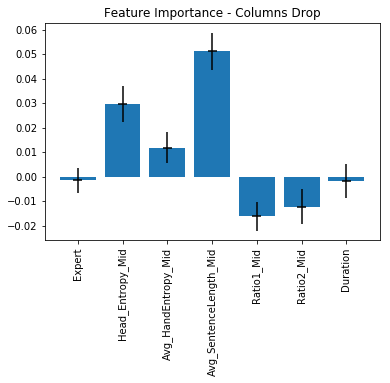

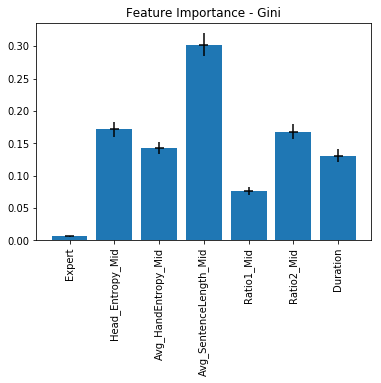

In [212]:

#print(all_scores)
all_scores_ = all_scores.drop(['fit_time', 'score_time'], axis=1).T
final = pd.DataFrame(index=all_scores_.index)

final['means'] = all_scores_.mean(axis=1)
final['std'] = all_scores_.std(axis=1)
final['sem'] = all_scores_.sem(axis=1)
final['confidence'] = all_scores_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)



final_fi = all_dropcol_features_importances.T
final_fi['means'] = final_fi.mean(axis=1)
final_fi['std'] = final_fi.std(axis=1)
final_fi['sem'] = final_fi.sem(axis=1)
final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Columns Drop', 
                final_fi['means'],
                final_fi['confidence'],
                subject_features_nophase, 
                sort=False)


final_fi_ = all_feature_importances.T
final_fi_['means'] = final_fi_.mean(axis=1)
final_fi_['std'] = final_fi_.std(axis=1)
final_fi_['sem'] = final_fi_.sem(axis=1)
final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Gini', 
                final_fi_['means'],
                final_fi_['confidence'],
                subject_features_nophase, 
                sort=False)


In [107]:
unpacked = [[p[key] for p in best_params] for key in best_params[0].keys()]
df = pd.DataFrame(data=np.vstack((scores, unpacked))).T
df.columns=['score', 'max_features', 'n_estimators', 'max_depth', 'min_samples_leaf']
print(df.sort_values(by=['score'], ascending=False))

      score max_features n_estimators max_depth min_samples_leaf
0  0.878095         None          100      None                1
3  0.837778         auto          100      None                1
6  0.825079         auto          100      None                1
1  0.815556         None          100         5                1
2  0.813356         None          100      None                1
5  0.810635         auto          100      None                1
9  0.785556         auto          100         5                1
4  0.783039         auto          100         5                1
8  0.773968         None          100         5                1
7  0.761451         auto          100         5                1


In [108]:
print(df.describe())

            score max_features  n_estimators  max_depth  min_samples_leaf
count   10.000000            6            10          5                10
unique  10.000000            1             1          1                 1
top      0.783039         auto           100          5                 1
freq     1.000000            6            10          5                10


In [117]:
dfu = pd.DataFrame(grid.cv_results_)
dfu[['mean_test_f1_macro', 'std_test_f1_macro']]
print(np.mean(dfu[['mean_test_f1_macro']]))
print(dfu['std_test_f1_macro'])
print(np.square(dfu['std_test_f1_macro']))

mean_test_f1_macro    0.646716
dtype: float64
0     0.099310
1     0.150313
2     0.114089
3     0.091315
4     0.136336
5     0.121339
6     0.091315
7     0.136336
8     0.121339
9     0.091315
10    0.136336
11    0.121339
12    0.105714
13    0.111815
14    0.114223
15    0.103319
16    0.121836
17    0.120246
18    0.103319
19    0.121836
20    0.120246
21    0.103319
22    0.121836
23    0.120246
24    0.115931
25    0.150313
26    0.114089
27    0.119221
28    0.136336
29    0.121339
30    0.119221
31    0.136336
32    0.121339
33    0.119221
34    0.136336
35    0.121339
36    0.099310
37    0.150313
38    0.114089
39    0.091315
40    0.136336
41    0.121339
42    0.091315
43    0.136336
44    0.121339
45    0.091315
46    0.136336
47    0.121339
Name: std_test_f1_macro, dtype: float64
0     0.009862
1     0.022594
2     0.013016
3     0.008338
4     0.018588
5     0.014723
6     0.008338
7     0.018588
8     0.014723
9     0.008338
10    0.018588
11    0.014723
12    0.011175

In [4]:
import pandas as pd
import scipy
import scipy.stats as st 

data = pd.DataFrame({
     "exp1":[34, 41, 39] 
    ,"exp2":[45, 51, 52]
    ,"exp3":[29, 31, 35]
}).T

data.loc[:,"row_mean"] = data.mean(axis=1)
data.loc[:,"row_std"] = data.std(axis=1)

mean_of_means = data.row_mean.mean()
std_of_means = data.row_mean.std()
tscore = st.t.ppf(1-0.025, data.shape[0]-1)

print("mean(means): {}\nstd(means): {}\ntscore: {}".format(mean_of_means,std_of_means,tscore))

lower_bound = mean_of_means - (tscore*std_of_means/(data.shape[0]**0.5))
upper_bound = mean_of_means + (tscore*std_of_means/(data.shape[0]**0.5))


print("95% CI = [{},{}]".format(lower_bound,upper_bound))
data

mean(means): 39.6666666667
std(means): 8.95048105473
tscore: 4.30265272991
95% CI = [17.4324391395,61.9008941939]


,0,1,2,row_mean,row_std
exp1,34,41,39,38.000000,2.943920
exp2,45,51,52,49.333333,3.091206
exp3,29,31,35,31.666667,2.494438
